In [1]:
import yfinance as yf

In [2]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [3]:
from scipy.stats import norm
from scipy.stats import lognorm

In [4]:
from pandas import to_datetime
import pandas as pd
from pandas_datareader import data as pdr
yf.pdr_override()

In [5]:
import numpy as np
import math
from datetime import date

In [6]:
import warnings
warnings.filterwarnings("ignore")

In [7]:
class Options:
    def __init__(self, symbol, r, T, M, N, start_date, end_date = date.today(), numDates=None):
        self.symbol = symbol
        self.start_date = start_date
        self.end_date = end_date
        #self.hist = yf.download(symbol, start=start_date, end=end_date) #Download history for the given symbol
        self.hist = pdr.get_data_yahoo(symbol, start_date, end_date)
        self.hist.reset_index(inplace=True,drop=False)
        self.contractData = yf.Ticker(symbol)
        self.returns = ((self.hist["Adj Close"] -self.hist["Adj Close"].shift(-1)) / self.hist["Adj Close"].shift(-1)).dropna()
        self.mu = np.mean(np.log(1 + self.returns))
        self.sigma = np.std(np.log(1 + self.returns))
        self.DF_calls, self.DF_puts = self.contractData.option_chain(self.contractData.options[0])
        self.S0 = self.hist["Adj Close"].iloc[-1] # current stock price
        self.r = r # risk-free rate
        self.T = T # time to maturity
        self.M = M # number of time steps
        self.N = N # number of simulations
        #self.q = 0.03 # annual dividend rate
        self.priceMatrix = np.zeros((self.N, self.M+1))
        self.periodicity = ['Day', 'Week', 'Month']
        if numDates==None:
            numDates = len(self.contractData.options)
        self.superDF_calls = self.contractList('C',numDates)
        self.superDF_puts = self.contractList('P',numDates)
        
    def monteCarlo(self, T=None, show='Hide'):
        if T==None:
            T = self.T
        dt = T / self.M
        self.priceMatrix[:, 0] = self.S0
        for i in range(self.N):
            for j in range(1, self.M+1):
                self.priceMatrix[i, j] = self.priceMatrix[i, j-1] * np.exp((self.r - 0.5 * self.sigma**2) * dt + self.sigma * np.sqrt(dt) * np.random.normal())
        fig, ax = plt.subplots()
        ax.plot(self.priceMatrix.T)
        ax.set_xlabel("Time")
        ax.set_ylabel("Stock Price")
        ax.set_title("Simulated Stock Price")
        fig.savefig('./Plots/Monte Carlo/'+self.symbol+'.png')
        if show=='Show':
            plt.show()
        plt.close()
        
    def plotSimulationStock(self):
        histogram((self.priceMatrix.T)[self.M-1,:],self.N)
        
    def splitPeriod(self, period):
        if period == 'Day':
            price = self.hist
        elif period == 'Week':
            self.hist['Day'] = (to_datetime(self.hist['Date'])).dt.day_name()
            price = self.hist.loc[self.hist['Day'] == 'Monday']
        else:
            price = self.hist.groupby(pd.DatetimeIndex(self.hist['Date']).to_period('M')).nth(0)
        return price
    
    def calcReturns(self, period):
        self.returns = self.splitPeriod(period)
        
    def plotPricesAllPeriod(self):
        fig = plt.figure(1, figsize=(15.0, 8.0))
        for i in range(len(self.periodicity)):
            plt.subplot(2, len(self.periodicity), i+1)
            self.plotPrices(self.periodicity[i])
            plt.title(symbol)
        fig.savefig('./Plots/Historic/'+self.symbol+'.png')
        fig.show()
    
    def plotPrices(self, period='Day'):
        price = self.splitPeriod(period)
        X = np.arange(len(price))
        Y = np.array(price['Close'])
        plt.xlabel("Time")
        plt.ylabel("Index Value")
        plt.plot(X, Y, label=period)
        plt.legend()
        
    def modellingStock(self, period, bins=50, show='Hide'):
        price = self.splitPeriod(period)
        ret = np.array(((price['Adj Close']-price['Adj Close'].shift(-1))/price['Adj Close'].shift(-1)).dropna())
        muRet = np.mean(ret)
        sigmaRet = np.std(ret)
        normRet = (ret - muRet)/sigmaRet
        logRet = np.log(1 + ret)
        meanLRet = np.mean(logRet)
        sigmaLRet = np.std(logRet)
        normLRet = (logRet - meanLRet)/sigmaLRet
        plt.subplot(2, 2, 1)
        plt.title(symbol + " Period: " + str(period))
        plt.xlabel("Normalised Log Return")
        plt.ylabel("Frequency")
        plt.hist(normLRet, bins=bins, color='orange', edgecolor='black', linewidth=0.3, density=True)
        muNorm, sigNorm = 0, 1
        X = np.linspace(min(normLRet), max(normLRet), len(normLRet))
        Y = (1/(2*np.pi*(sigNorm**2))**0.5)*np.exp(-0.5*(X-muNorm)**2/(sigNorm)**2)
        plt.plot(X, Y, color='blue', label = "Standard Normal")
        plt.legend()
        plt.subplot(2,2, 2)
        plt.title(symbol + " Period: " + str(period))
        plt.ylabel("Normalised Log Return")
        plt.boxplot(normRet)
        if show=="Show":
            plt.show()
        plt.close()
        qqplot = sm.qqplot(normRet, line ='45')
        qqplot.savefig('./Plots/Analysis Historic/'+self.symbol+'_qq_'+period+'.png')
        if show=="Show":
            plt.show()
        plt.close()
        
    def modellingStockAllPeriod(self, show='Hide'):
        for i in range(len(self.periodicity)):
            fig = plt.figure(2, figsize=(15.0, 8.0))
            self.modellingStock(self.periodicity[i], show=show)
            fig.savefig('./Plots/Analysis Historic/'+self.symbol+'.png')
            fig.show()
        
    def contractList(self,choice,rng):  #to get multiple contract list table with a given range(rng). Use 'P' for put and 'C' for call in choice parameter.
        superDF_calls,superDF_puts=self.contractData.option_chain(self.contractData.options[0])
        for i in range(1,rng):
            calls1,puts1=self.contractData.option_chain(self.contractData.options[i])
            if choice == 'C':
                superDF_calls=pd.concat([superDF_calls,calls1],ignore_index=True)
            else:
                superDF_puts=pd.concat([superDF_puts,puts1],ignore_index=True)
        if choice == 'C':
            return superDF_calls
        else:
            return superDF_puts
        
    def blackScholesOption(self,K, optType='call', T=None):
        if T==None:
            T = self.T
        d1 = (np.log(self.S0/K) + (self.r + self.sigma**2/2)*T) / self.sigma*np.sqrt(T)
        d2 = d1 - self.sigma* np.sqrt(T)
        if optType=='call':
            opt = self.S0 * norm.cdf(d1) - K * np.exp(-self.r*T)*norm.cdf(d2)
        elif optType=='put':
            opt =  K * np.exp(-self.r*T)*norm.cdf(-d2) - self.S0 * norm.cdf(-d1)
        return opt
    
    def simulationOption(self,K, optType='call', T=None):
        if T==None:
            T = self.T
        if optType=='call':
            payoffs = np.maximum(self.priceMatrix[-1]-K, 0)
        elif optType=='put':
            payoffs = np.maximum(K-self.priceMatrix[-1], 0)
        option_price = np.mean(payoffs)*np.exp(-self.r*T) #discounting back to present value
        return option_price
    
    def contractExtract(self, loc):
        contractSym = self.superDF_calls['contractSymbol'].iloc[loc]
        expDate = date(int('20'+ contractSym[len(self.symbol):len(self.symbol)+2]), int(contractSym[len(self.symbol)+2:len(self.symbol)+4]), int(contractSym[len(self.symbol)+4:len(self.symbol)+6]))
        strikePrice = int(contractSym[len(self.symbol)+7:])/1000
        return expDate, strikePrice
    
    def retNumOptions(self, optType='call'):
        if optType=='call':
            return(len(self.superDF_calls))
        elif optType=='put':
            return(len(self.superDF_puts))
    
    def downloadOptData(self, sym):
        self.superDF_calls.to_csv('./Data/'+sym+'_calls.csv')
        self.superDF_puts.to_csv('./Data/'+sym+'_puts.csv')

In [8]:
symbol = "TSLA"
startDate = "2021-04-08"
r = 0.05
T = 9/365
M = 500
N = 500
stk = Options(symbol, r, T, M, N, startDate)

[*********************100%***********************]  1 of 1 completed


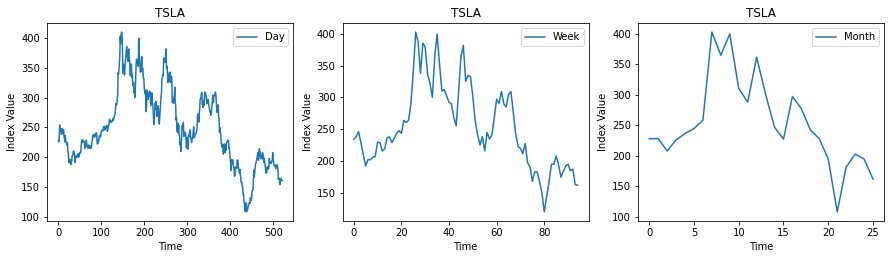

In [9]:
stk.plotPricesAllPeriod()

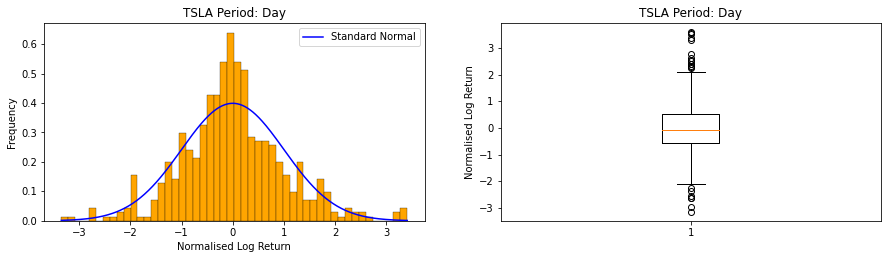

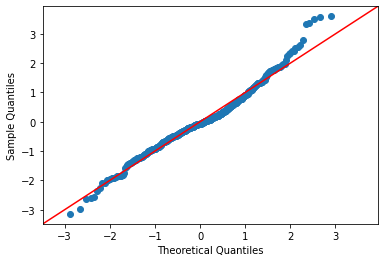

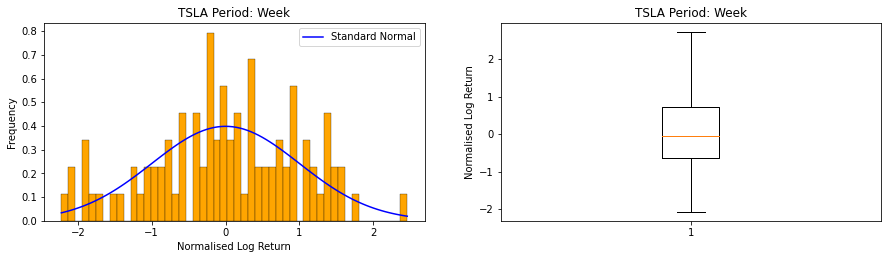

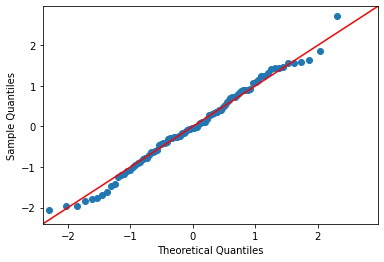

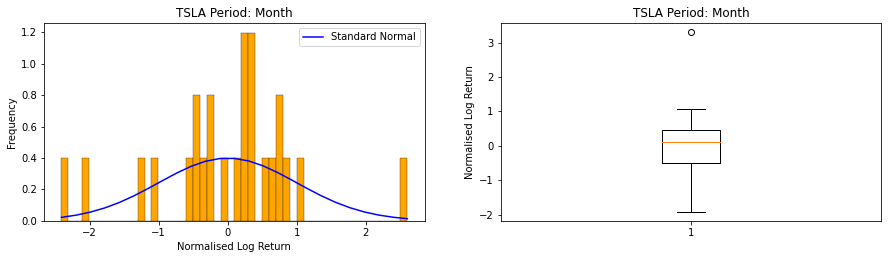

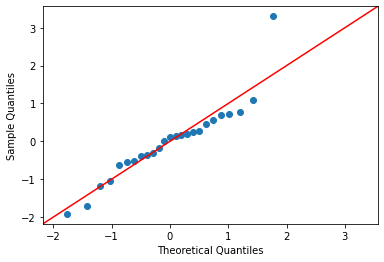

In [10]:
stk.modellingStockAllPeriod('Show')

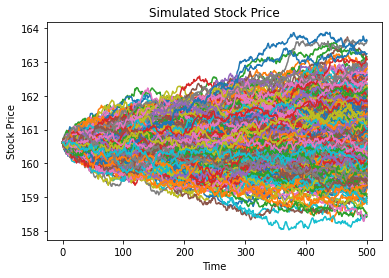

In [11]:
stk.monteCarlo(show='Show')

In [12]:
def testSingle(symbol, dateStart, dateEnd = date.today(), show='Hide', optType='call'):
    stock =  Options(symbol, r, T, M, N, dateStart, dateEnd, numDates=1)
    stock.modellingStockAllPeriod(show='Hide')
    expDate, currStrike = stock.contractExtract(0)
    timeToExp = (expDate-date.today()).days
    stock.monteCarlo(timeToExp/365)
    bcmPr = stock.blackScholesOption(currStrike,optType, timeToExp/365)
    simPr = stock.simulationOption(currStrike, optType, timeToExp/365)
    lastPrice = stock.superDF_calls['lastPrice'].iloc[0]
    bid = stock.superDF_calls['bid'].iloc[0]
    ask = stock.superDF_calls['ask'].iloc[0]
    print("BSM Price = ", bcmPr)
    print("Sim Price = ", simPr)
    print("Bid = ", bid, "\tAsk = ", ask, "Last Price = ", lastPrice)
    
testSingle(symbol, startDate)

[*********************100%***********************]  1 of 1 completed
BSM Price =  140.3160752566453
Sim Price =  140.48037706719018
Bid =  140.9 	Ask =  141.15 Last Price =  140.3


In [13]:
def testMulti(symList, dateStart, dateEnd = date.today(), show='Hide', optType='call'):
    startDate = [dateStart]*len(symList)
    for i in range(len(symList)):
        stock =  Options(symList[i], r, T, M, N, startDate[i], dateEnd, numDates=1)
        stock.modellingStockAllPeriod(show='Hide')
        expDate, currStrike = stock.contractExtract(0)
        timeToExp = (expDate-date.today()).days
        stock.monteCarlo(timeToExp/365)
        bcmPr = stock.blackScholesOption(currStrike,optType, timeToExp/365)
        simPr = stock.simulationOption(currStrike, optType, timeToExp/365)
        lastPrice = stock.superDF_calls['lastPrice'].iloc[0]
        bid = stock.superDF_calls['bid'].iloc[0]
        ask = stock.superDF_calls['ask'].iloc[0]
        print("Symbol = ", symList[i])
        print("BSM Price = ", bcmPr)
        print("Sim Price = ", simPr)
        print("Bid = ", bid, "\tAsk = ", ask, "Last Price = ", lastPrice)

#symbolList = ["AAPL","TSLA","NVS","GOGL","META","LYFT","AI","SOFI","LCID","NVO"]
symbolList = ["AAPL","TSLA","NVS","GOGL","META"]
dateStart = "2021-04-08"
testMulti(symbolList, dateStart)

[*********************100%***********************]  1 of 1 completed
Symbol =  AAPL
BSM Price =  117.41791937101345
Sim Price =  117.45813716284042
Bid =  115.5 	Ask =  115.7 Last Price =  115.65
[*********************100%***********************]  1 of 1 completed
Symbol =  TSLA
BSM Price =  140.3160752566453
Sim Price =  140.4903099393704
Bid =  140.9 	Ask =  141.15 Last Price =  140.3
[*********************100%***********************]  1 of 1 completed
Symbol =  NVS
BSM Price =  22.119185114721574
Sim Price =  22.086067958396324
Bid =  19.7 	Ask =  24.5 Last Price =  17.48
[*********************100%***********************]  1 of 1 completed
Symbol =  GOGL
BSM Price =  5.955131521446564
Sim Price =  5.956821630881258
Bid =  5.6 	Ask =  5.8 Last Price =  6.38
[*********************100%***********************]  1 of 1 completed
Symbol =  META
BSM Price =  217.01618754542997
Sim Price =  216.8990699676964
Bid =  216.75 	Ask =  217.05 Last Price =  219.75


[*********************100%***********************]  1 of 1 completed


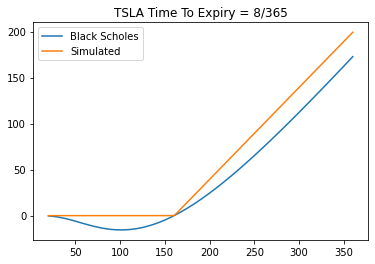

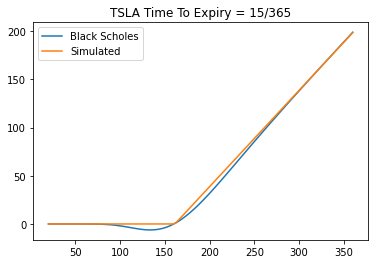

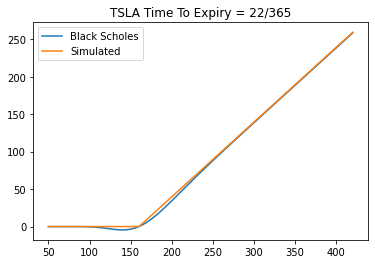

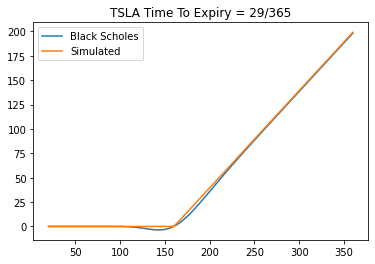

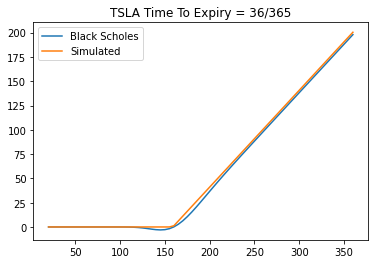

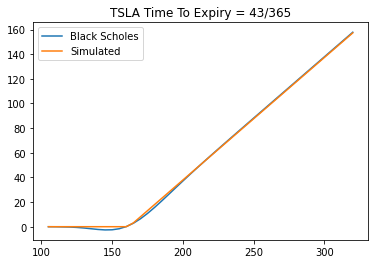

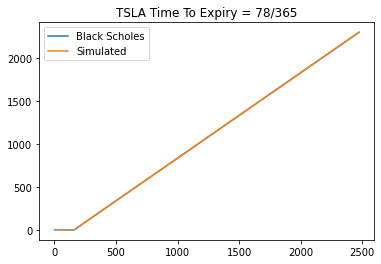

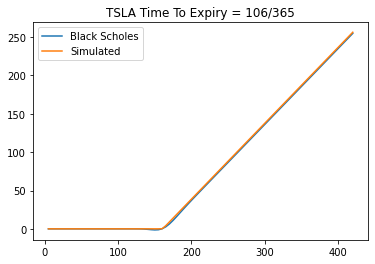

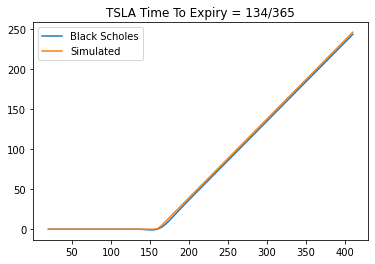

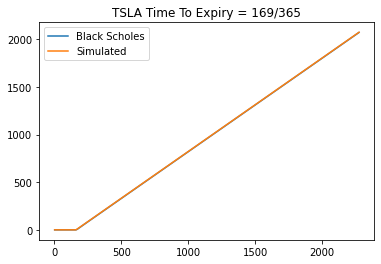

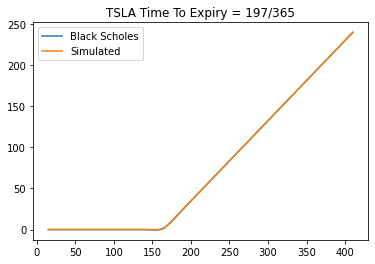

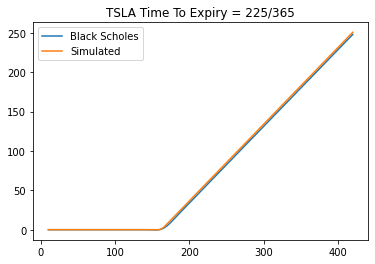

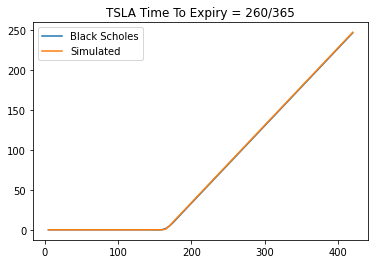

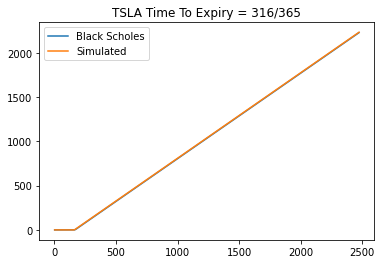

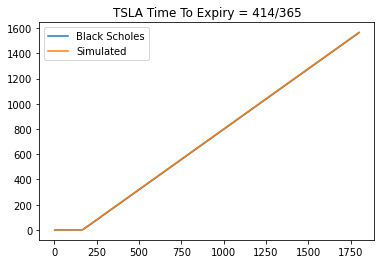

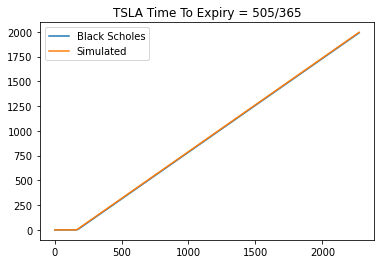

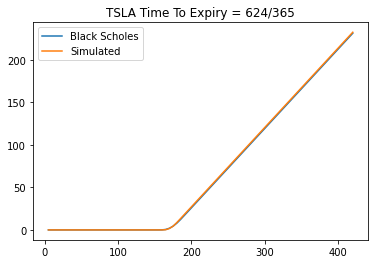

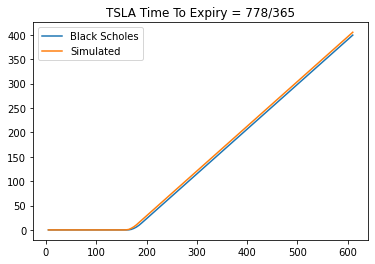

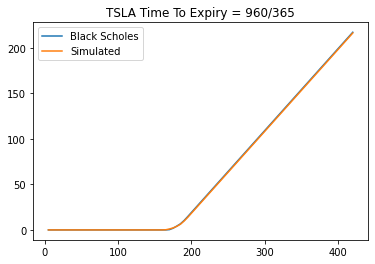

In [14]:
def OptionsVsExpTime():
    prevExpDate = None
    length = stk.retNumOptions(optType='call')
    for j in range(length):
        expDate, currStrike = stk.contractExtract(j)
        timeToExp = (expDate-date.today()).days
        if prevExpDate == timeToExp:
            strikePrice.append(currStrike)
            bsmPrice.append(stk.blackScholesOption(currStrike,'put', timeToExp/365))
            simPrice.append(stk.simulationOption(currStrike,'put', timeToExp/365))
        if prevExpDate != timeToExp or j==length-1:
            stk.monteCarlo(timeToExp/365)
            prevExpDate = timeToExp
            if j!=0:
                fig = plt.figure()
                plt.title(symbol + ' Time To Expiry = ' + str(timeToExp) +'/365')
                plt.plot(strikePrice,bsmPrice,label="Black Scholes")
                plt.plot(strikePrice,simPrice,label="Simulated")
                plt.legend()
                fig.savefig('./Plots/Analysis MC/Time To Expiry/' + symbol + '_T_' + str(timeToExp) + '.png')
            strikePrice = []
            bsmPrice = []
            simPrice = []
            strikePrice.append(currStrike)
            bsmPrice.append(stk.blackScholesOption(currStrike,'put',timeToExp/365))
            simPrice.append(stk.simulationOption(currStrike,'put',timeToExp/365))
    plt.close()

stk = Options(symbol, r, T, M, N, startDate)
OptionsVsExpTime()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


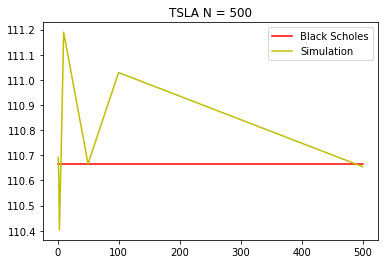

In [15]:
def OptionsVsN(pathLen=None, avg=5): 
    if pathLen==None:
        pathLen = [1,2,3,5,10,50,100,500]
    l = len(pathLen)
    N_list = np.zeros(l)
    stk = Options(symbol, r, T, M, 1, startDate)
    expDate, currStrike = stk.contractExtract(100)
    timeToExp = (expDate-date.today()).days
    bsmPrice = [stk.blackScholesOption(currStrike, 'call', timeToExp/365)]*l
    for i in range(l):
        stk = Options("TSLA",0.05,timeToExp/365,500,pathLen[i], startDate)
        for j in range(avg):
            stk.monteCarlo(timeToExp/365)
            N_list[i] += stk.simulationOption(currStrike, 'call', timeToExp/365)/avg
    fig = plt.figure()
    plt.title(symbol + ' N = ' + str(pathLen[i]))
    plt.plot(pathLen, bsmPrice, color='r', label='Black Scholes')
    plt.plot(pathLen, N_list, color='y', label='Simulation')
    plt.legend()
    fig.savefig('./Plots/Analysis MC/Number of Iter/' + symbol + '_N' + '.png')
    plt.show()
    plt.close()

OptionsVsN()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

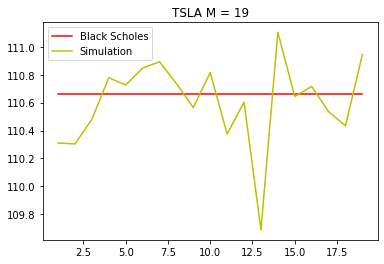

In [16]:
def OptionsVsM(pathSteps=None, avg=5):   
    if pathSteps==None:
        pathSteps = [i for i in range(1,20)]
    l = len(pathSteps)
    M_list = np.zeros(l)
    stk = Options(symbol, r, T, M, 1, startDate)
    expDate, currStrike = stk.contractExtract(100)
    timeToExp = (expDate-date.today()).days
    bsmPrice = [stk.blackScholesOption(currStrike, 'call', timeToExp/365)]*l
    for i in range(l):
        stk = Options("TSLA",0.05,timeToExp/365,pathSteps[i],500, startDate)
        for j in range(avg):
            stk.monteCarlo(timeToExp/365)
            M_list[i] += stk.simulationOption(currStrike, 'call', timeToExp/365)/avg
    fig = plt.figure()
    plt.title(symbol + ' M = ' + str(pathSteps[i]))
    plt.plot(pathSteps, bsmPrice, color='r', label='Black Scholes')
    plt.plot(pathSteps, M_list, color='y', label='Simulation')
    plt.legend()
    fig.savefig('./Plots/Analysis MC/Number of Steps/' + symbol + '_M' + '.png')
    plt.show()
    plt.close()
    
OptionsVsM()